# CH04.3. **게이트 순환 유닛(Gated Recurrent Unit)**

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 1000
USE_PRETRAIN_YN = 'N'
MODEL_PTH = '../../model/kospiSeqGRU.pt'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import random
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import torch
import torchinfo

#(2) Set options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)
pd.options.display.float_format = '{:.4f}'.format

#(3) Define device(hardware)
if torch.backends.mps.is_available() :
    device = torch.device(device='mps')
else :
    device = torch.device(device='cpu')
print(f'>> Device : {device}')

>> Device : mps


#### 00.2. **사용자정의함수 정의**

In [3]:
#(1) Define `describe_df()` function
def describe_df(df:pd.DataFrame) :
    output = pd.DataFrame(data={
        'dataType'     : df.dtypes,
        'nullCount'    : df.isnull().sum(),
        'nonNullCount' : (df.shape[0]-df.isnull().sum()),
        'uniqueCount'  : df.nunique()
    })
    return output

#(2) Define `make_seq_data()` function
def make_seq_data(df:pd.DataFrame, target:str, seq_length:int) :
    X = df.drop(labels=target, axis=1).values
    y = df.loc[:, target].values
    output = []
    for i in range(len(X)-seq_length) : 
        output.append([X[i:i+seq_length].tolist(), y[i+seq_length]])
    return output

#(3) Define `compute_rmse()` function
def compute_rmse(model:torch.nn, loader:torch.utils.data.DataLoader) :
    model.eval()
    with torch.no_grad() : 
        square_sum = 0
        num_instances = 0
        for inputs, targets in loader :
            inputs = inputs.to(device=device) 
            targets = targets.to(device=device)
            preds = model(x=inputs)
            square_sum += torch.sum(input=(preds - targets)**2).item()
            num_instances += len(targets)
    model.train()
    output = np.sqrt(square_sum/num_instances)
    return output

#(4) Define `plot_compare()` function
def plot_compare(model:torch.nn, train_loader:torch.utils.data.DataLoader, test_loader:torch.utils.data.DataLoader) :
    outputs_train = []
    targets_train = []
    outputs_test = []
    targets_test = []
    model.eval()
    with torch.no_grad():
        for inputs, targets in train_loader :
            inputs = inputs.to(device=device)
            outputs = model(x=inputs)
            outputs_train += outputs.cpu().numpy().tolist()
            targets_train += targets.numpy().tolist()
        for inputs, targets in test_loader :
            inputs = inputs.to(device=device)
            outputs = model(x=inputs)
            outputs_test += outputs.cpu().numpy().tolist()
            targets_test += targets.numpy().tolist()
    model.train()
    outputs = outputs_train + outputs_test
    targets = targets_train + targets_test
    plt.figure(figsize=(16, 8))
    plt.plot(outputs, label='Predictions', color='blue', linestyle='-', linewidth=0.6)
    plt.plot(targets, label='Actual', color='red', linestyle='--',  linewidth=0.6)
    plt.axvline(x=len(targets_train), label='Train Boundary', color='grey', linestyle='--', linewidth=0.6)
    plt.xlabel(xlabel='Time Step')
    plt.ylabel(ylabel='Value')
    plt.legend()
    plt.grid(False)
    plt.show()

#### 00.3. **클래스 정의**

In [4]:
#(1) Define `MyTensorDataset` class
class MyTensorDataset(torch.utils.data.Dataset) :
    def __init__(self, seq_data:np.array, data_type:torch.dtype=torch.float32) :
        features = []
        targets = []
        for i in range(len(seq_data)) : 
            features.append(seq_data[i][0])
            targets.append(seq_data[i][1])
        self.feature = torch.tensor(data=features, dtype=data_type)
        self.target = torch.tensor(data=targets, dtype=data_type).reshape(shape=(-1, 1))
        self.len = self.target.shape[0]
    def __getitem__(self, index) :
        return self.feature[index], self.target[index]
    def __len__(self) :
        return self.len
    
#(2) Define `MySequenceModel` class
class MySequenceModel(torch.nn.Module) :
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device) :
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.layers = torch.nn.ModuleDict()
        self.layers['gru'] = torch.nn.GRU(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True
        )
        self.layers['fc'] = torch.nn.Linear(in_features=hidden_size*sequence_length, out_features=1)
        self.to(device=self.device)
    def forward(self, x) :
        h0 = torch.zeros(size=(self.num_layers, x.size()[0], self.hidden_size), device=self.device)
        x = self.layers['gru'](x, h0)[0]
        x = x.reshape(shape=(x.shape[0], -1))
        x = self.layers['fc'](x)
        return x

<b></b>

## 01. **데이터셋 로드 및 EDA**

#### 01.1. **데이터셋 로드**

In [5]:
kospi_raw = pd.read_csv(filepath_or_buffer='../../data/kospi.csv', index_col=[0])

#### 01.2. **EDA**

In [6]:
#(1) Display `kospi_raw`
# kospi_raw.head(n=10)

In [7]:
#(2) Describe `kospi_raw`
# describe_df(df=kospi_raw)

In [8]:
#(3) Check the statistics of `kospi_raw`
# kospi_raw.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).transpose()

<b></b>

## 02. **데이터셋 전처리**

#### 02.3. **학습 및 검증 데이터셋 분리**

In [9]:
#(1)
kospi = kospi_raw.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']].copy()

#(2)
train_size = 0.5
train_idx = int(len(kospi)*train_size)

#(3)
kospi_train = kospi.iloc[:train_idx]
kospi_test = kospi.iloc[train_idx:]

#### 02.1. **스케일링 처리**

In [10]:
#(1)
scaler = sklearn.preprocessing.MinMaxScaler()

#(2)
kospi_train = pd.DataFrame(
    data=scaler.fit_transform(X=kospi_train), 
    columns=kospi.columns
)
kospi_test = pd.DataFrame(
    data=scaler.transform(X=kospi_test), 
    columns=kospi.columns
)

#### 02.2. **시퀀스 데이터로 변환** (윈도우 크기 : $ 5 $)

In [11]:
#(1)
seq_length = 5

#(2)
kospi_train = make_seq_data(df=kospi_train, target='Close', seq_length=seq_length)
kospi_test = make_seq_data(df=kospi_test, target='Close', seq_length=seq_length)

#### 02.4. **텐서 변환**

In [12]:
kospi_train = MyTensorDataset(seq_data=kospi_train, data_type=torch.float32)
kospi_test = MyTensorDataset(seq_data=kospi_test, data_type=torch.float32)

#### 02.5. **데이터로더 변환**

In [13]:
kospi_train_loader = torch.utils.data.DataLoader(dataset=kospi_train, batch_size=BATCH_SIZE, shuffle=True)
kospi_test_loader = torch.utils.data.DataLoader(dataset=kospi_test, batch_size=BATCH_SIZE, shuffle=False)

<b></b>

## 03. **모델 구축 및 학습**

#### 03.1. **모델 정의**

In [14]:
input_size = kospi_train[0][0].shape[1]
num_layers = 2
hidden_size = 8

In [15]:
#(1) Define `model`
model = MySequenceModel(
    input_size=input_size, 
    hidden_size=hidden_size, 
    sequence_length=seq_length, 
    num_layers=num_layers,
    device=device
).to(dtype=torch.float32)

#(2) Display `model`
model

MySequenceModel(
  (layers): ModuleDict(
    (gru): GRU(4, 8, num_layers=2, batch_first=True)
    (fc): Linear(in_features=40, out_features=1, bias=True)
  )
)

In [16]:
#(3)
dummy = torch.randn(size=[BATCH_SIZE]+list(kospi_train[0][0].shape)).to(device=device)
torchinfo.summary(model=model, input_data=dummy)

Layer (type:depth-idx)                   Output Shape              Param #
MySequenceModel                          [32, 1]                   --
├─ModuleDict: 1-1                        --                        --
│    └─GRU: 2-1                          [32, 5, 8]                768
│    └─Linear: 2-2                       [32, 1]                   41
Total params: 809
Trainable params: 809
Non-trainable params: 0
Total mult-adds (M): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

In [17]:
#(4) Define loss function
criterion = torch.nn.MSELoss()

#(5) Define optimizer(optimization method)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=1e-7)

#(6) Define Scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#### 03.2. **학습 전 변수 정의**

In [18]:
batch_cnt = len(kospi_train_loader)
if USE_PRETRAIN_YN == 'Y' :
    checkpoint = torch.load(f=MODEL_PTH)
    model.load_state_dict(state_dict=checkpoint['model'])
    optimizer.load_state_dict(state_dict=checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss_hist = checkpoint['loss_hist']
    best_loss = loss_hist[-1]
else :
    epoch = 0
    loss_hist = []
    best_loss = float('inf')
print(f">> Epoch={epoch}, Train Loss={best_loss}")

>> Epoch=0, Train Loss=inf


#### 03.3. **모델 학습**

In [19]:
progress_bar = tqdm.trange(epoch, EPOCH_NUM)
for epoch in progress_bar : 
    running_loss = 0.0
    model.train()
    for inputs, targets in kospi_train_loader :
        inputs = inputs.to(device=device) 
        targets = targets.to(device=device)
        optimizer.zero_grad() 
        preds = model(x=inputs)
        loss = criterion(input=preds, target=targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss_avg = running_loss / batch_cnt
    loss_hist.append(running_loss_avg)
    if running_loss_avg < best_loss :
        best_loss = running_loss_avg
        torch.save(
            obj={
                'epoch'     : epoch,
                'loss_hist' : loss_hist,
                'model'     : model.state_dict(),
                'optimizer' : optimizer.state_dict()
            }, 
            f=MODEL_PTH
        )
    # scheduler.step()
    progress_bar.set_postfix(ordered_dict={'epoch':epoch+1, 'loss':running_loss}) 

100%|██████████| 1000/1000 [02:38<00:00,  6.30it/s, epoch=1000, loss=0.00886]


<b></b>

## 04. **모델 평가**

#### 04.1. **최적 성능 모델 로드**

In [20]:
checkpoint = torch.load(f=MODEL_PTH)
model.load_state_dict(state_dict=checkpoint['model'])
print(f'>> Epoch : {checkpoint["epoch"]}, Loss : {checkpoint["loss_hist"][-1]}')

>> Epoch : 989, Loss : 0.0002565896117760401


#### 04.2. **학습 손실(Traing Loss) 확인**

In [21]:
#(1) Check RMSE
rmse_train = compute_rmse(model=model, loader=kospi_train_loader)
print(f'>> Train RMSE: {rmse_train}')

>> Train RMSE: 0.015493565975915917


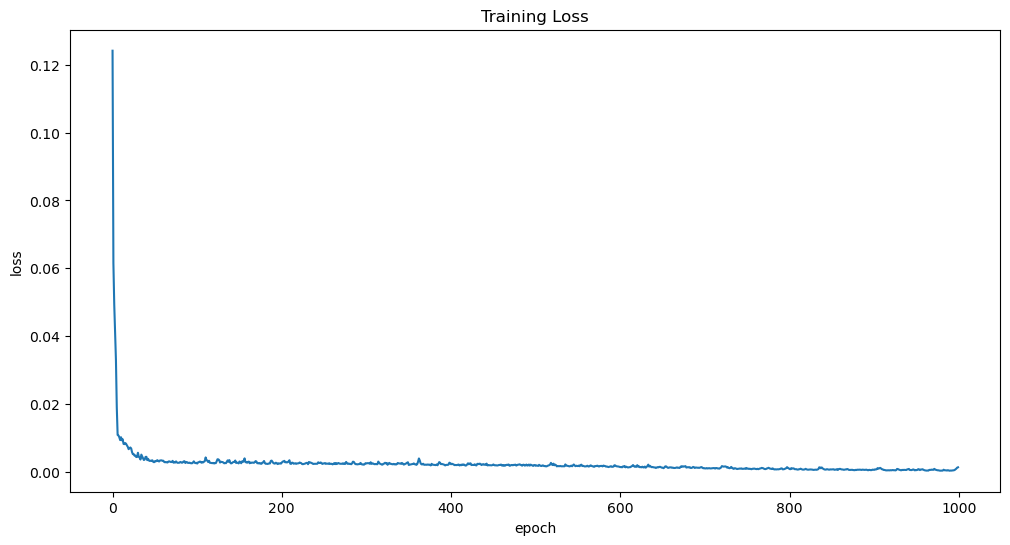

In [22]:
#(2) Plot traing loss
plt.figure(figsize=(12, 6))
plt.title(label='Training Loss')
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_hist)
plt.show()

#### 04.3. **성능 평가**

In [23]:
#(1)
rmse_test = compute_rmse(model=model, loader=kospi_test_loader)
print(f'>> Test RMSE : {rmse_test}')

>> Test RMSE : 0.35898847130312844


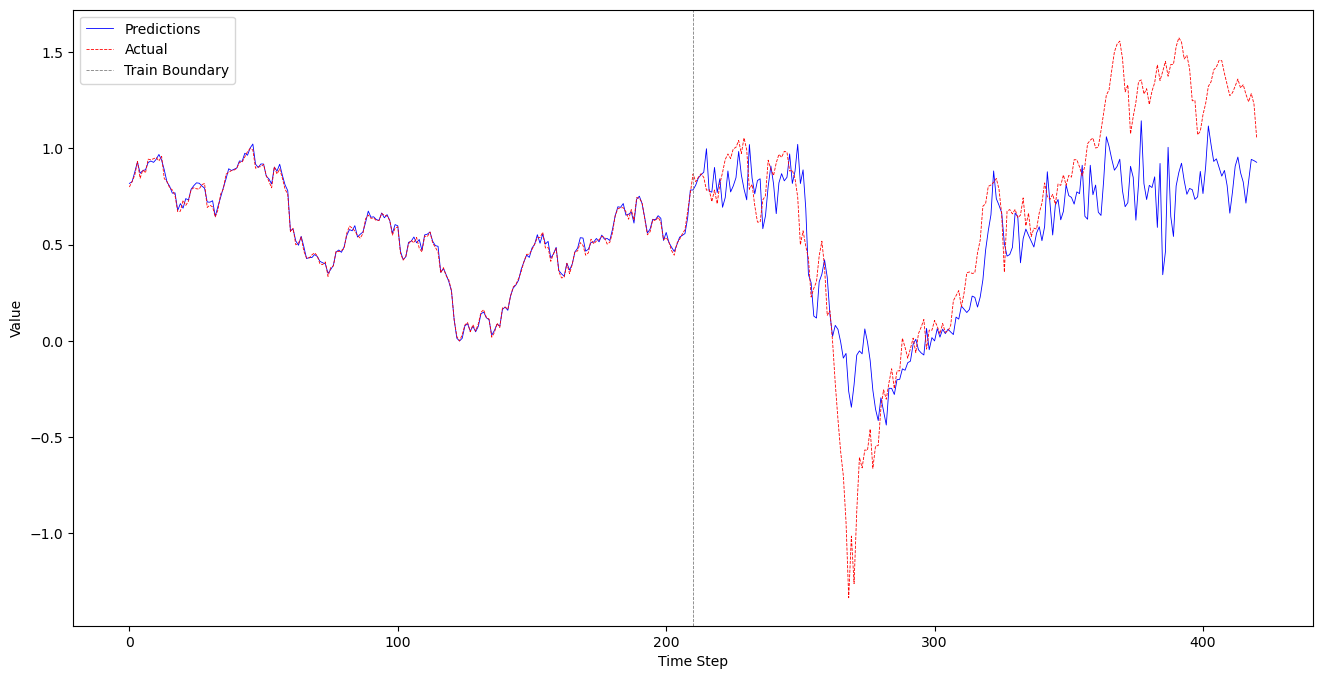

In [24]:
#(2)
kospi_train_loader = torch.utils.data.DataLoader(dataset=kospi_train, batch_size=BATCH_SIZE, shuffle=False)
plot_compare(model=model, train_loader=kospi_train_loader, test_loader=kospi_test_loader)